# Final Project 
## Analysis of Subway usage of Seoul using based on signal processing 

### How things go:
+ Obtain temporal Seoul subway usage data
+ Extract features using fourier transformation (or wavelet transfomr)
+ Cluster based on similarity
+ Analyze the result based on urban context

### 1. Obtain temporal Seoul subway usage data
+ Data is retrieved from [http://data.seoul.go.kr/dataList/OA-12252/S/1/datasetView.do]

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
raw_path = './Rawdata/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv'

raw_df = pd.read_csv(raw_path)
sample_df = raw_df[(raw_df['사용월'] < 202101) &(raw_df['사용월'] >= 202001)]

In [3]:
start_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(4, 24)]
end_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(0, 4)]

times = start_times + end_times
in_times = [i + '승차인원' for i in times]
out_times = [i + '하차인원' for i in times]

col_names = ['사용월', '호선명','지하철역']
in_cols = col_names + in_times
out_cols = col_names + out_times
in_df = sample_df[in_cols]
out_df = sample_df[out_cols]

in_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7196 entries, 2423 to 9618
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   사용월           7196 non-null   int64 
 1   호선명           7196 non-null   object
 2   지하철역          7196 non-null   object
 3   04시-05시 승차인원  7196 non-null   int64 
 4   05시-06시 승차인원  7196 non-null   int64 
 5   06시-07시 승차인원  7196 non-null   int64 
 6   07시-08시 승차인원  7196 non-null   int64 
 7   08시-09시 승차인원  7196 non-null   int64 
 8   09시-10시 승차인원  7196 non-null   int64 
 9   10시-11시 승차인원  7196 non-null   int64 
 10  11시-12시 승차인원  7196 non-null   int64 
 11  12시-13시 승차인원  7196 non-null   int64 
 12  13시-14시 승차인원  7196 non-null   int64 
 13  14시-15시 승차인원  7196 non-null   int64 
 14  15시-16시 승차인원  7196 non-null   int64 
 15  16시-17시 승차인원  7196 non-null   int64 
 16  17시-18시 승차인원  7196 non-null   int64 
 17  18시-19시 승차인원  7196 non-null   int64 
 18  19시-20시 승차인원  7196 non-null   int64 
 19  20시

In [6]:
in_df['지하철역']

2423    동대문
2424    동묘앞
2425    서울역
2426     시청
2427    신설동
       ... 
9614     원덕
9615     중랑
9616     지평
9617     팔당
9618     회기
Name: 지하철역, Length: 7196, dtype: object

In [17]:
# Add to shp file
import geopandas as gpd


station_path = './Rawdata/Seoul_subway.shp'

station_gdf = gpd.read_file(station_path, encoding = 'utf-8')

parsed_df = station_gdf['NAME'].str.split('(')
station_gdf['NAME'] = parsed_df.str.get(0)
parsed_df = station_gdf['NAME'].str[:-1]
station_gdf['NAME'] = parsed_df
station_list = [i for i in station_gdf['NAME']]
len(station_list)

293

In [21]:
in_df = in_df[in_df['지하철역'].isin(station_list)]
len(in_df['지하철역'].unique())

234

In [22]:
# Create pivot table dataframe
in_pivot = pd.pivot_table(in_df, index = ['지하철역', '사용월'])
in_pivot_df = in_pivot.stack().to_frame('influx')
in_pivot_df

influx
지하철역     사용월                        
4.19민주묘지 202001 00시-01시 승차인원   123.0
                01시-02시 승차인원     1.0
                02시-03시 승차인원     0.0
                03시-04시 승차인원     0.0
                04시-05시 승차인원     1.0
...                              ...
효창공원앞    202012 19시-20시 승차인원  6558.0
                20시-21시 승차인원  4107.5
                21시-22시 승차인원  3478.5
                22시-23시 승차인원  1524.0
                23시-24시 승차인원   619.0

[66432 rows x 1 columns]

In [23]:
# Reorganize multiindex of pivot table
row_to_col = in_pivot_df.unstack(level = -3) # Move the outermost row index to column
no_influx = row_to_col.droplevel(0, axis = 1) # Remove redundant column name "influx"
no_influx.index = no_influx.index.set_levels(no_influx.index.levels[0].astype(str), level = 0 ) # Change date int type to str for merging
no_influx.index = no_influx.index.map('_'.join) # Merge multi index into one index
in_df_cols = no_influx
print(in_df_cols)
#in_df_cols = no_influx.droplevel(0) # Remove the innermost row index "사용월"

지하철역                 4.19민주묘지     가락시장  가산디지털단지       가양     가오리      가좌  \
202001_00시-01시 승차인원     123.0    752.5   1060.5    773.0   175.0    35.0   
202001_01시-02시 승차인원       1.0      6.5      3.5      4.0     3.0     0.0   
202001_02시-03시 승차인원       0.0      0.0      0.0      1.0     0.0     0.0   
202001_03시-04시 승차인원       0.0      0.0      0.0      0.0     0.0     0.0   
202001_04시-05시 승차인원       1.0     14.0    725.5     88.0     8.0     0.0   
...                       ...      ...      ...      ...     ...     ...   
202012_19시-20시 승차인원    1806.0  10252.0  79766.5  16136.0  2133.0  3616.0   
202012_20시-21시 승차인원    1747.0   8627.0  46110.0  12013.0  1540.0  2571.0   
202012_21시-22시 승차인원    1152.0   8248.0  36926.0  10197.0  1091.0  2361.0   
202012_22시-23시 승차인원     550.0   2591.0  11808.0   3998.0   695.0  1299.0   
202012_23시-24시 승차인원     209.0    721.5   3161.0    915.0   214.0   441.0   

지하철역                       강남     강남구청       강동    강동구청  ...       한티  \
202001_00시-01시

In [24]:
sample_cols = in_df_cols
print(sample_cols)

지하철역                 4.19민주묘지     가락시장  가산디지털단지       가양     가오리      가좌  \
202001_00시-01시 승차인원     123.0    752.5   1060.5    773.0   175.0    35.0   
202001_01시-02시 승차인원       1.0      6.5      3.5      4.0     3.0     0.0   
202001_02시-03시 승차인원       0.0      0.0      0.0      1.0     0.0     0.0   
202001_03시-04시 승차인원       0.0      0.0      0.0      0.0     0.0     0.0   
202001_04시-05시 승차인원       1.0     14.0    725.5     88.0     8.0     0.0   
...                       ...      ...      ...      ...     ...     ...   
202012_19시-20시 승차인원    1806.0  10252.0  79766.5  16136.0  2133.0  3616.0   
202012_20시-21시 승차인원    1747.0   8627.0  46110.0  12013.0  1540.0  2571.0   
202012_21시-22시 승차인원    1152.0   8248.0  36926.0  10197.0  1091.0  2361.0   
202012_22시-23시 승차인원     550.0   2591.0  11808.0   3998.0   695.0  1299.0   
202012_23시-24시 승차인원     209.0    721.5   3161.0    915.0   214.0   441.0   

지하철역                       강남     강남구청       강동    강동구청  ...       한티  \
202001_00시-01시

[0, 24, 48, 72]


<Figure size 432x288 with 0 Axes>

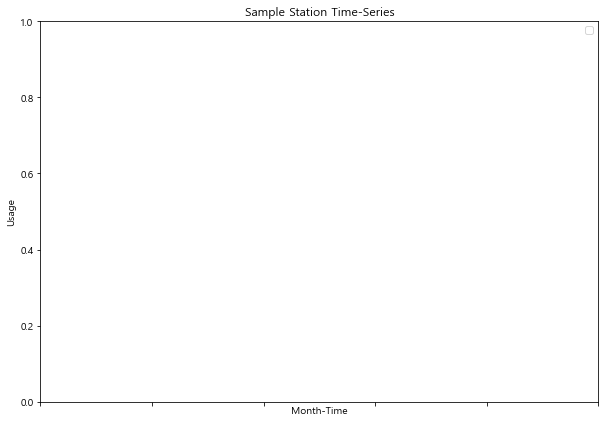

In [26]:
#Visualize the time-usage graph

plt.clf()
xi = [i*24 for i in range(4)]
print(xi)
fig = plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Usage')
#plt.plot(sample_cols)
plt.title('Sample Station Time-Series')
plt.tick_params(axis = 'x', labelbottom = False)
#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])
plt.legend(sample_cols.columns)
plt.show()
fig.savefig('./final_fig/copy_fig_0.png')

In [27]:
def norm_col(df, col):
    return col/df[col].max()
norm_cols = pd.DataFrame()
for col in sample_cols:
    norm_cols[col] = sample_cols[col] / sample_cols[col].max()

#norm_cols = sample_cols.apply(norm_col, axis = 1)
plt.clf()
'''
ax, fig = ax, plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.plot(norm_cols)
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])
plt.legend(norm_cols.columns, loc = 2)
plt.show()
fig.savefig('./final_fig/copy_fig_1.png')
'''

"\nax, fig = ax, plt.figure(figsize = (10, 7))\nplt.rc('font', family = 'Malgun Gothic')\nplt.xlabel('Month-Time')\nplt.ylabel('Normalized Usage')\nplt.plot(norm_cols)\nplt.title('Sample Station Time-Series - Normalized')\nplt.tick_params(axis = 'x', labelbottom = False)\n#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])\nplt.legend(norm_cols.columns, loc = 2)\nplt.show()\nfig.savefig('./final_fig/copy_fig_1.png')\n"

<Figure size 432x288 with 0 Axes>

### 2. Extract features using fourier transformation (or wavelet transfomr)

In [84]:
# Import Wavelet and decompose
import pywt
w = pywt.Wavelet('db4')
wavelet_cols = pd.DataFrame()
for k, v in enumerate(norm_cols):
    cA, cD = pywt.dwt(norm_cols[v], wavelet = w)
    cA10 = sorted(cA, reverse = True)
    cD10 = sorted(cD, reverse = True)
    ext_cA = cA10[:3]
    ext_cD = cD10[:3]
    wavelet_cols[v] = [i for i in zip(ext_cA, ext_cD)]
wavelet_cols


,4.19민주묘지,가락시장,가산디지털단지,가양,가오리,가좌,강남,강남구청,강동,강동구청,...,한티,합정,행당,혜화,홍대입구,홍제,화계,화곡,회기,효창공원앞
0,"(1.2424718945725644, 0.08128960805062051)","(1.1603288369997518, 0.30363306078071534)","(0.9942557274606743, 0.31698387473646533)","(1.3303192637752066, 0.10254298134148818)","(1.3481574017128701, 0.06244917368947739)","(1.258439033493213, 0.12739530892981565)","(1.1358291767655344, 0.21494786159729012)","(0.9677370219541142, 0.3370931002582301)","(1.221089146701403, 0.12571803761370742)","(1.1661755416920683, 0.19402093286025002)",...,"(1.3305697150208509, 0.2561754200986108)","(1.1205067028024644, 0.24076576337831157)","(1.1477699340822862, 0.20253188141348807)","(1.3338289095381028, 0.14507316698886602)","(1.3647697060153294, 0.15176967623014337)","(1.2469613599297857, 0.09095603990070542)","(1.232086725136179, 0.08209397439380157)","(1.2211133273564063, 0.15269773154237046)","(1.1506602621304078, 0.11685915813338671)","(1.0891399705038585, 0.29389212755030253)"
1,"(1.1838700954845072, 0.07346146894652884)","(1.1048945630509979, 0.29754221346937376)","(0.9537993733253715, 0.31614213326109797)","(1.3021704871195914, 0.091762295336419)","(1.3156718760360835, 0.056635828916575016)","(1.1946382009650351, 0.11025907771772572)","(1.133629122077819, 0.2118532410072184)","(0.9245971672904377, 0.32912303626567424)","(1.1758312579418793, 0.12260808725506453)","(1.110176806300508, 0.18917567477846528)",...,"(1.1311953466156945, 0.20713136589664533)","(1.0699656116571308, 0.23740284172244622)","(1.09570796152687, 0.19431501190696293)","(1.1450308259875914, 0.14354804951767458)","(1.3377365150361835, 0.1444433706204338)","(1.190541581489258, 0.08830439325955004)","(1.1812274437806254, 0.07554331025287776)","(1.1747859692945803, 0.1398530245558482)","(1.139010989440427, 0.09661907965157775)","(1.0846682096232287, 0.2885298517140879)"
2,"(1.1149220151036339, 0.07013244684157358)","(1.0443473498992373, 0.28491768248834404)","(0.9351435005617038, 0.31119427951923195)","(1.2791174034329764, 0.08512196462740043)","(1.2721628554160884, 0.05335676769259575)","(1.1749516136002502, 0.09608812396943117)","(1.0172335770144785, 0.1836466807161903)","(0.9120272378330214, 0.3171239984232917)","(1.0885954989489461, 0.11249374334563891)","(1.0956349151825016, 0.18668939730976383)",...,"(1.0823868643403483, 0.198282279349543)","(0.9991339107815929, 0.2322591485672245)","(1.0888399977668262, 0.1688733908150002)","(1.1021621417861895, 0.14234963425993544)","(1.3329534625779302, 0.12930391876559028)","(1.1708759189109113, 0.07455120276411856)","(1.1236506369951769, 0.07367190757917876)","(1.1744048049497928, 0.12907531753565438)","(1.119514219832679, 0.0944038553889011)","(1.030748122886628, 0.2870045552552113)"


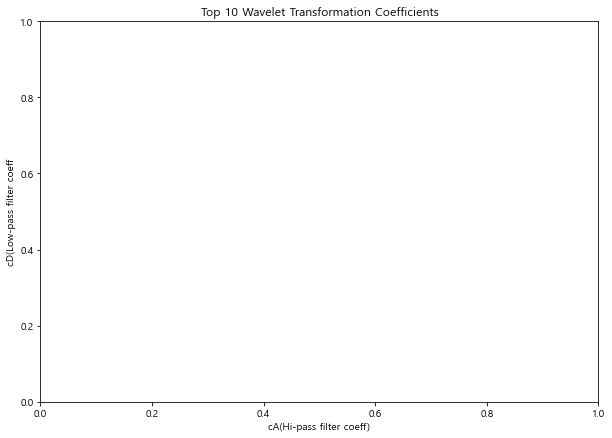

In [85]:
#import seaborn as sns
plt.rc('font', family = 'Malgun Gothic')

fig1 = plt.figure(figsize = (10, 7))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Top 10 Wavelet Transformation Coefficients')
#plt.legend(wavelet_cols.columns)
for v in wavelet_cols:
    temp = list(wavelet_cols[v])
    cA, cD = zip(*temp)
    #plt.scatter(x = cA, y = cD)
    #plt.annotate(v, (max(cA), max(cD)), size = 10)
plt.show()
fig1.savefig('./Final_fig/copy_fig_2.png')

### 3.Cluster based on similarity

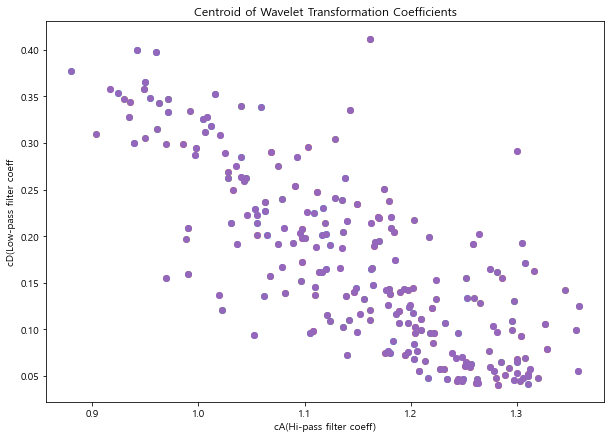

In [86]:
def get_cent(col):
    n = len(col)
    temp = list(col)
    x, y = zip(*temp)
    cent_x = sum(x)/n
    cent_y = sum(y)/n
    return (cent_x, cent_y)
cent_cols = pd.DataFrame()

fig2 = plt.figure(figsize = (10, 7))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Centroid of Wavelet Transformation Coefficients')
for v in wavelet_cols:
    cent_cols[v] = get_cent(wavelet_cols[v])
    plt.scatter(cent_cols[v].iloc[0], cent_cols[v].iloc[1])
    #plt.annotate(v, (cent_cols[v].iloc[0], cent_cols[v].iloc[1]), size = 10)
plt.scatter(cent_cols.iloc[0], cent_cols.iloc[1])
plt.show()
fig2.savefig('./Final_fig/copy_fig_3.png')

In [87]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import numpy as np
drop_cent_cols = cent_cols.dropna(axis = 1)
np_cols = drop_cent_cols.T.to_numpy()
num_cluster = 4
kmeans = KMeans(n_clusters = num_cluster, random_state = 0).fit(np_cols)
labeled = pd.DataFrame(kmeans.labels_, index = drop_cent_cols.columns, columns = ['label'])
'''
DBSCAN_ = DBSCAN(min_samples = num_cluster).fit(np_cols)
labeled = pd.DataFrame(DBSCAN_.labels_, index = cent_cols.columns, columns = ['label'])
BotUp = AgglomerativeClustering(n_clusters = num_cluster).fit(np_cols)
labeled = pd.DataFrame(BotUp.labels_, index = cent_cols.columns, columns = ['label'])
'''
#cent_cols.T
labeled_cols = cent_cols.append(pd.DataFrame(labeled).T).T
labeled_cols.columns = ['cA', 'cD', 'label']
labeled_cols

,cA,cD,label
4.19민주묘지,1.180421,0.074961,0.0
가락시장,1.103190,0.295364,3.0
가산디지털단지,0.961066,0.314773,1.0
가양,1.303869,0.093142,2.0
가오리,1.311997,0.057481,2.0
...,...,...,...
홍제,1.202793,0.084604,0.0
화계,1.178988,0.077103,0.0
화곡,1.190101,0.140542,0.0
회기,1.136395,0.102627,0.0


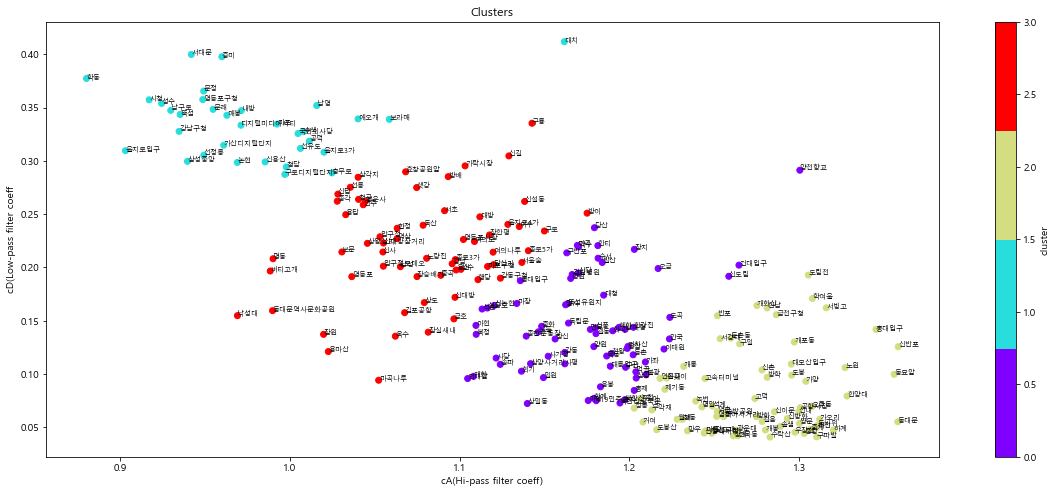

In [90]:
plt.rc('font', family = 'Malgun Gothic')
fig3 = plt.figure(figsize = (20, 8))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Clusters')
plt.scatter(x = 'cA', y = 'cD',data = labeled_cols, c = 'label', cmap = plt.cm.get_cmap('rainbow', num_cluster))

for i, name in enumerate(labeled_cols.index):
    plt.annotate(name, (labeled_cols.loc[name]['cA'], labeled_cols.loc[name]['cD']), size = 7)
plt.colorbar(label = 'cluster')
plt.show()
fig3.savefig('./Final_fig/copy_fig_4.png')

<ipython-input-112-f67ba78f8d79>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


<Figure size 432x288 with 0 Axes>

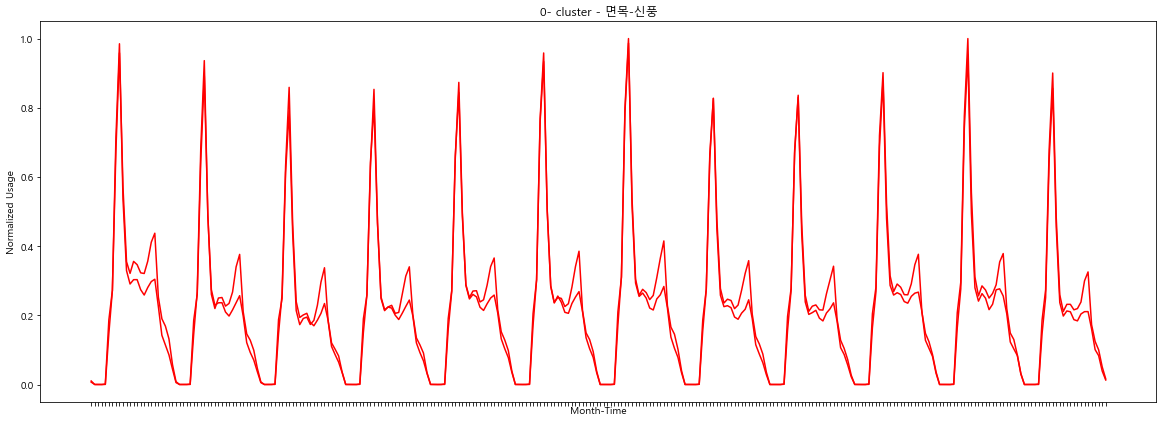

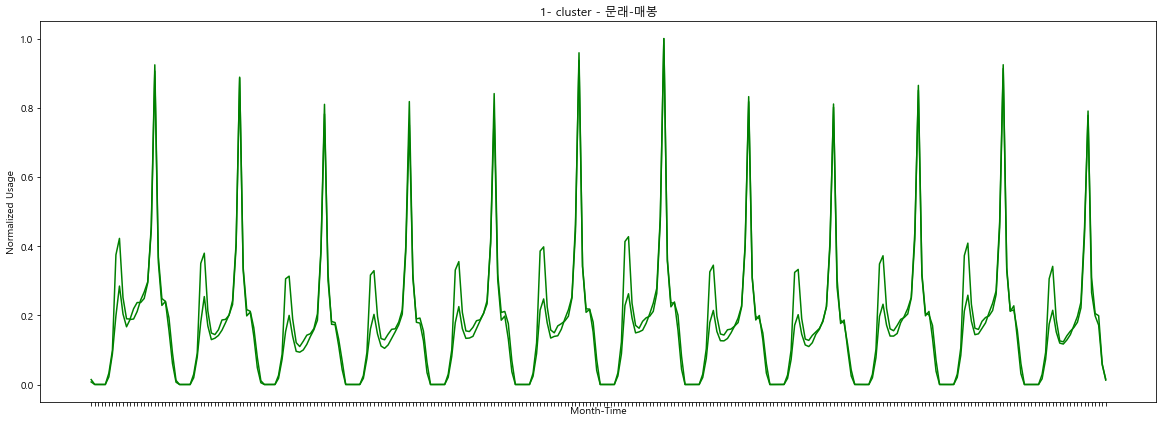

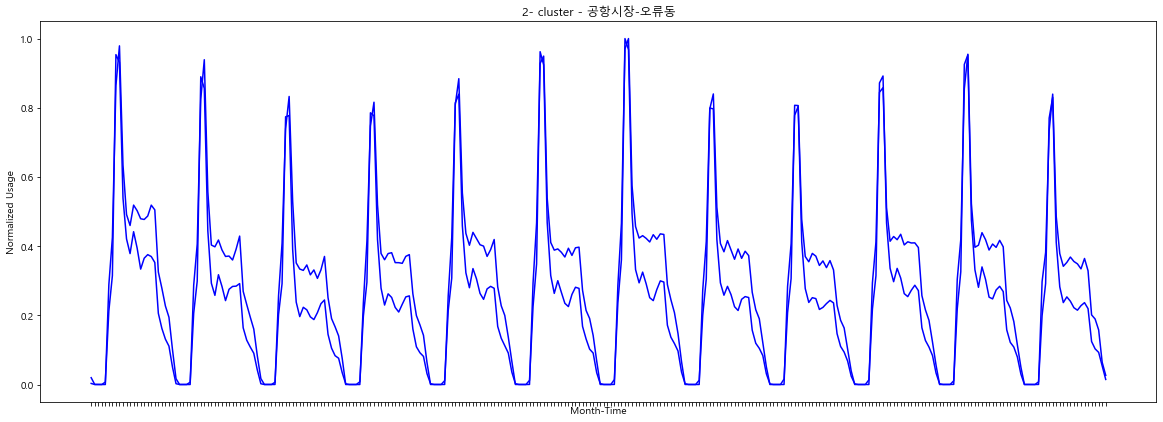

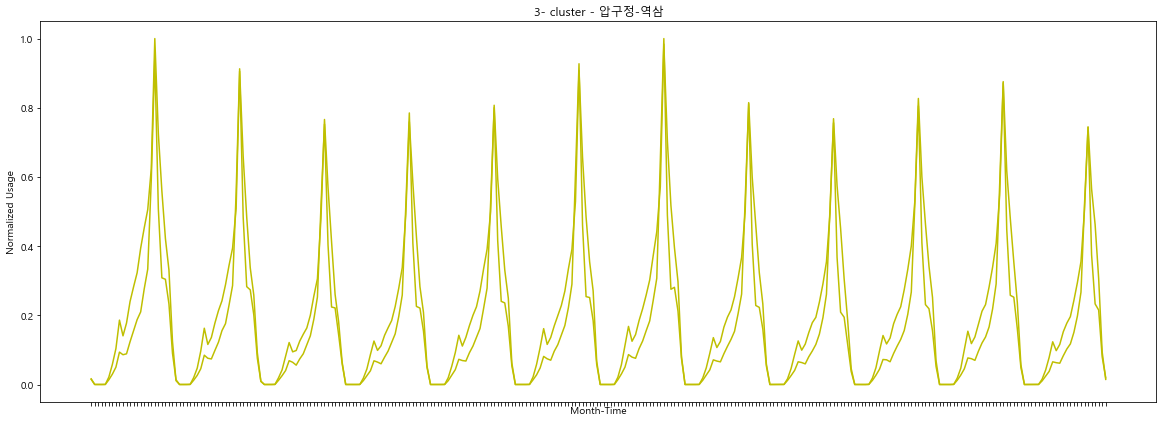

In [112]:
from random import sample
cluster_dict = {}
for i in range(num_cluster):
    test = labeled_cols.query('label == {}'.format(i)).index.tolist()
    cluster_dict[i] = test
plt.clf()
'''
plt.rc('font', family = 'Malgun Gothic')
fig5, ax = plt.subplots(figsize = (20, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
'''
sample_items = {0: ['면목', '신풍'], 1: ['문래', '매봉'], 2: ['공항시장', '오류동'], 3: ['압구정', '역삼']}
c_list = [plt.cm.rainbow(i) for i in cluster_dict.keys()]
c_list2 = ['r','g','b','y']
fig3.show()
for k, v in sample_items.items():
    samples = sample(v, 2)
    fig5, ax = plt.subplots(figsize = (20, 7))
    plt.rc('font', family = 'Malgun Gothic')
    plt.xlabel('Month-Time')
    plt.ylabel('Normalized Usage')
    text = str(k) +'- cluster - '+ samples[0] + '-' + samples[1]
    plt.title(text)
    plt.tick_params(axis = 'x', labelbottom = False)
    ax.plot(norm_cols[samples], color = c_list2[k])
    plt.show()
    fig5.savefig('./Final_fig/copy_fig_5_{}.png'.format(k))

#fig5.savefig('./Final_fig/copy_fig_5.png')

In [94]:
st_to_cluster = {'NAME' : [], 'Cluster' : []}
for k, v in cluster_dict.items():
    for i in v:
        st_to_cluster['NAME'].append(i)
        st_to_cluster['Cluster'].append(k)
st_cluster_df = pd.DataFrame(st_to_cluster, columns = ['NAME', 'Cluster'])
len(st_cluster_df['NAME'])

234

In [95]:
cluster_gdf = pd.merge(station_gdf, st_cluster_df, on = 'NAME')

In [99]:
cluster_gdf.to_file('./Final_fig/clustered_station.shp', encoding = 'utf-8')


In [101]:
#Read Buffer data
buffer_path = './Final_fig/cluster_restau_price_resid.shp'
df = gpd.read_file(buffer_path)
print(df)

                  UFID     NAME  BJCD  SCLS  FMTA  Cluster  NUM_Resta  \
0    TRN120000000004LZ       복정  None  None  None        0        0.0   
1    TRN120000000004N1       마천  None  None  None        2      211.0   
2    TRN120000000004O2       거여  None  None  None        2      211.0   
3    TRN120000000004P3       개롱  None  None  None        2      133.0   
4    TRN120000000004Q4       장지  None  None  None        0      346.0   
..                 ...      ...   ...   ...   ...      ...        ...   
234  TRN12000000000IUM      오류동  None  None  None        2      259.0   
235  TRN12000000000IZR  가산디지털단지  None  None  None        1      508.0   
236  TRN12000000000J0T      신대방  None  None  None        3      194.0   
237  TRN12000000000J1U  구로디지털단지  None  None  None        1      432.0   
238  TRN12000000000J3W     금천구청  None  None  None        2       57.0   

       Price_mean  NUM_Res                                           geometry  
0    5.135000e+06      4.0  POLYGON ((96739

In [110]:
from scipy.stats import norm
means = df.groupby('Cluster').mean()
varis = df.groupby('Cluster').var()
means

,NUM_Resta,Price_mean,NUM_Res
Cluster,,,
0,277.457143,6.608992e+06,553.214286
1,428.727273,1.115874e+07,309.060606
2,211.424658,5.427307e+06,375.205479
3,365.873016,1.013442e+07,419.984127
